In [49]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import lognorm, shapiro

# scikit learn
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Reading the data

In [2]:
df = None
file_path = Path('/home/device1/predictive_ml/datasets/diabetes_prediction_dataset.csv')
if file_path.exists():
    df = pd.read_csv(file_path)

In [3]:
# Seems to be no missing values
# 'diabetes' is the target class

df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [6]:
# No missing values
# smoking_history has categorical values which imply there are missing values in them
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [7]:
# around 3900 duplicates 
df[df.duplicated()].shape[0]

3854

## Data Cleaning

### Remove duplicates

In [9]:
# See the number of samples in the DataFrame
df.shape[0]

100000

In [10]:
print(f'Before dropping : {df.shape[0]}')
print(f'Number of duplicates : {df[df.duplicated()].shape[0]}')
# Drop the duplicates
df.drop_duplicates(subset=None, keep='first', inplace=True)

# After dropping number of duplicates
print(f'After dropping : {df.shape[0]}')
print(f'After dropping duplicates - num of duplicates: {df[df.duplicated()].shape[0]}')

Before dropping : 100000
Number of duplicates : 3854
After dropping : 96146
After dropping duplicates - num of duplicates: 0


In [11]:
def getDuplicateColumns(df):
    """
    To find the duplicated columns
    """

    # Create an empty set
    duplicateColumnNames = set()

    # Iterate through all the columns of dataframe
    for x in range(df.shape[1]):

        # Take column at xth index.
        col = df.iloc[:, x]

        # Iterate through all the columns
        for y in range(x + 1, df.shape[1]):

            # Take column at yth index.
            otherCol = df.iloc[:, y]

            # Check if two columns at x & y
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])

    return list(duplicateColumnNames)

# seems to be no duplicate columns
duplicate_cols = getDuplicateColumns(df)
if duplicate_cols:
    print(duplicate_cols)
else:
    print("No duplicate columns")

No duplicate columns


## Data exploration

In [12]:
df['diabetes'].value_counts()

diabetes
0    87664
1     8482
Name: count, dtype: int64

In [20]:
# As you can see it is an imbalanced class problem
round(df[df['diabetes'] == 1].shape[0] / df.shape[0] * 100 , 3)


8.822

### Diabetes - Class imbalance

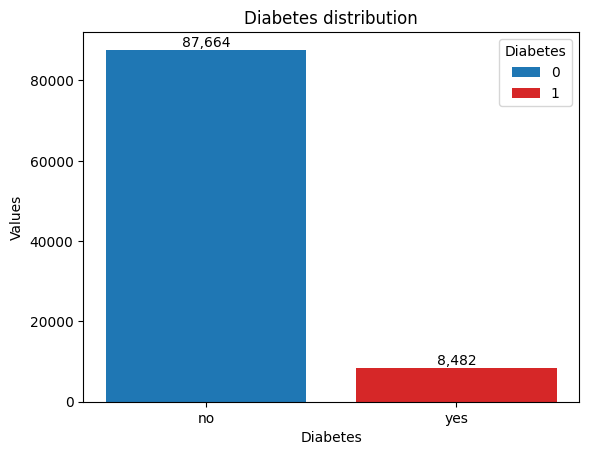

In [32]:
fig, ax = plt.subplots()

labels = df['diabetes'].value_counts().index

bar_labels = df['diabetes'].value_counts().index
values = df['diabetes'].value_counts().values
bar_colors = ['tab:blue', 'tab:red']

bar_container = ax.bar(labels, values, label=bar_labels, color=bar_colors)
ax.set_ylabel('Values')
ax.set_xlabel('Diabetes')
ax.set_xticks(range(2), ['no', 'yes'])
ax.set_title('Diabetes distribution')
ax.legend(title='Diabetes')
ax.bar_label(bar_container, fmt='{:,.0f}')

plt.show()

### Diabetes and BMI

In [39]:
# Intuitively BMI should have a link
df['bmi'].std()

np.float64(6.767715560480338)

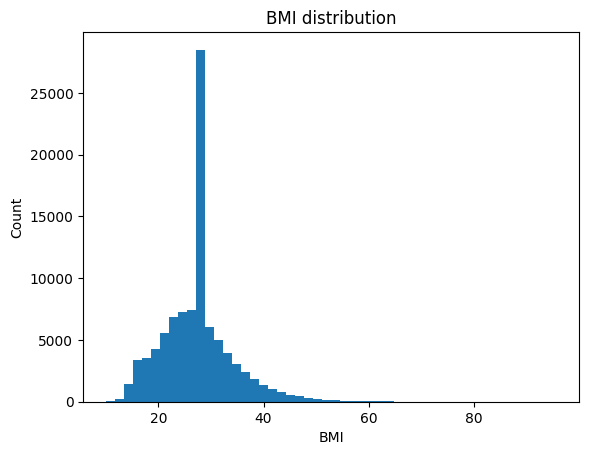

In [42]:
fig, ax = plt.subplots()

# bar_container = ax.bar(labels, values, label=bar_labels, color=bar_colors)
ax.hist(df['bmi'], bins=50, density=False)
ax.set_ylabel('Count')
ax.set_xlabel('BMI')
ax.set_title('BMI distribution')

plt.show()

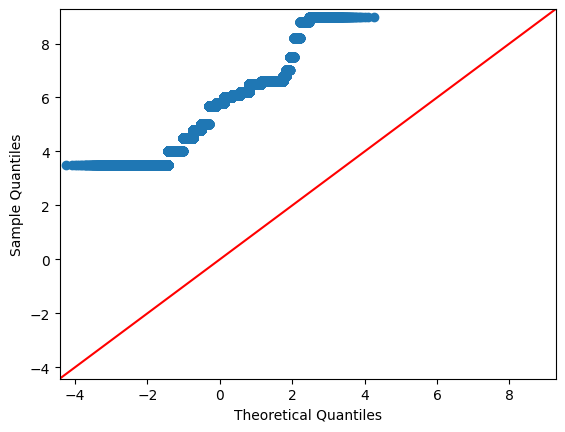

In [48]:
# Here we can see that it isnt normally distributed
fig = sm.qqplot(df['HbA1c_level'], line='45')
plt.show()

In [50]:
shapiro(df['bmi'])

/home/device1/envs/predictive_ml_learn/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 96146.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=np.float64(0.933042768613795), pvalue=np.float64(9.300235947518393e-101))

In [52]:
random.sample(df['bmi'].values, 1000)

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [59]:
import random
x = random.sample([float(item) for item in list(df['bmi'].values)], 1000)
shapiro(x)

ShapiroResult(statistic=np.float64(0.906936992122507), pvalue=np.float64(3.2246442155875005e-24))

In [60]:
del(x)

In [47]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [34]:
# Intuitively BMI should have a link
# Really no difference between bmi for diabetes
df.groupby('diabetes').agg({'bmi' : ['median', 'max']}).reset_index()

diabetes     bmi       
            median    max
0        0  27.320  95.69
1        1  29.985  88.72

In [26]:
# Blood glucose shows a significant difference for diabetes patients
x = df.groupby('diabetes').agg({'blood_glucose_level' : ['median', 'max']}).reset_index()

diabetes blood_glucose_level     
                        median  max
0        0               140.0  200
1        1               160.0  300

### Blood Glucose Level

In [29]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


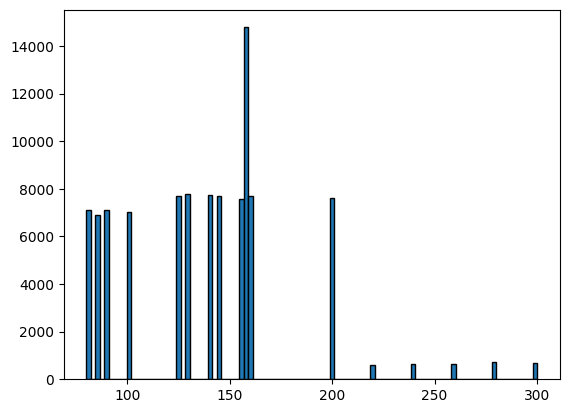

In [32]:
# BLood glucose levels show that it is has a lot of discrete numerical values
plt.hist(df['blood_glucose_level'], bins =100, edgecolor = 'black')
plt.show()

In [35]:
# Essentially categorical since there are discrete numerical values
df['blood_glucose_level'].nunique()

18

In [ ]:
df[df[]

### Age and the relation with target class

In [24]:
# Age has influence on the target class value

x = df.groupby('diabetes').agg({'age' : ['median', 'max']}).reset_index()
x.columns = ['diabetes', 'age_median', 'age_max']
x

,diabetes,age_median,age_max
0,0,40.0,80.0
1,1,62.0,80.0


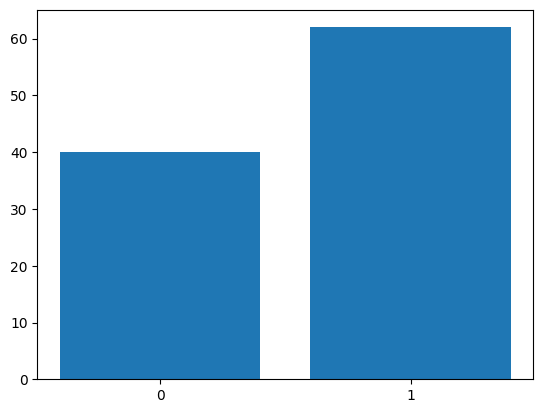

In [50]:
plt.bar([0,1], x['age_median'])
plt.xticks([0,1])
plt.show()

In [70]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [78]:
df['hypertension'].value_counts()

hypertension
0    92515
1     7485
Name: count, dtype: int64

In [80]:
# Mostly women dataset
df['gender'].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [83]:
# Gender is important in this case to 
# diabetes is more linked to diabetes

df.groupby(['gender', 'diabetes'])['age'].count()

gender  diabetes
Female  0           54091
        1            4461
Male    0           37391
        1            4039
Other   0              18
Name: age, dtype: int64

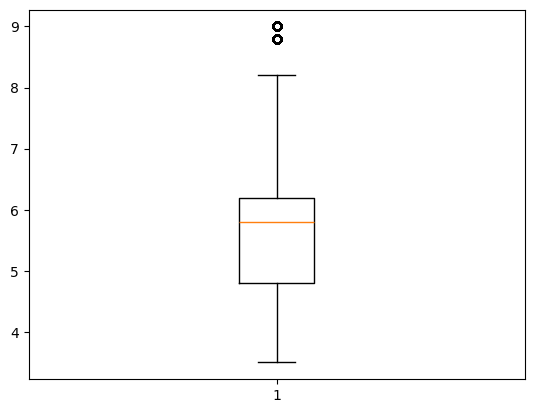

In [75]:
plt.boxplot(df['HbA1c_level'])
plt.show()

### For smoking history data manipulation

In [73]:
# Clearly 
df['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [72]:
df.groupby(['smoking_history', 'diabetes'])['bmi'].count()

smoking_history  diabetes
No Info          0           34362
                 1            1454
current          0            8338
                 1             948
ever             0            3532
                 1             472
former           0            7762
                 1            1590
never            0           31749
                 1            3346
not current      0            5757
                 1             690
Name: bmi, dtype: int64

### Outlier Detection

In [89]:
def find_outliers(feature_name : None):
    """."""
    try:
        if bool(feature_name) == False or feature_name not in df.columns:
            raise ValueError(f'incorrect feature name {feature_name} given')
            
        if df[feature_name].dtype == 'int' or df[feature_name].dtype == 'float':
            #  find the 1st and 3rd quartiles
            percentile_25 = float(df[feature_name].describe()['25%'])
            percentile_75 = float(df[feature_name].describe()['75%'])
            # get the upper and lower bounds
            IQR = percentile_75 - percentile_25 
            upper_bound = percentile_75 + 1.5 * IQR
            lower_bound = percentile_25 - 1.5 * IQR
            # find the idx
            neg_outliers = list(df[df[feature_name] < lower_bound].index)
            pos_outliers = list(df[df[feature_name] > upper_bound].index)

            idx_lst = neg_outliers + pos_outliers
            return 'success', feature_name, idx_lst, neg_outliers, pos_outliers
    
    except ValueError as val_err:
        return val_err, None, None, None, None
    
    except Exception as e:
        return str(e), None, None, None, None
    

In [92]:
msg, feature_name, idx_lst, neg_outliers, pos_outliers = find_outliers('bmi')
if msg!= 'success':
    print(f'Error : {msg}')
else:
    # here we find those with BMI outliers have 
    pass

# it seems like within if-else logic the cells do not execute
df.loc[idx_lst]['diabetes'].value_counts()

diabetes
0    5608
1    1478
Name: count, dtype: int64

In [61]:
df.loc[idx_lst]

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
24,Female,4.00,0,0,No Info,13.99,4.0,140,0
155,Female,0.08,0,0,No Info,14.43,6.5,160,0
221,Male,6.00,0,0,No Info,13.79,6.5,160,0
264,Female,4.00,0,0,No Info,13.57,3.5,126,0
268,Female,0.16,0,0,No Info,12.15,6.6,100,0
296,Female,2.00,0,0,No Info,14.69,5.0,159,0
396,Male,0.16,0,0,No Info,14.35,6.5,126,0
475,Female,4.00,0,0,No Info,14.00,5.0,160,0
677,Female,0.88,0,0,No Info,10.30,5.7,100,0
819,Female,2.00,0,0,No Info,14.70,4.0,80,0


In [93]:
# lower_bound = float(df['blood_glucose_level'].describe()['25%']) 
# upper_bound = float(df['blood_glucose_level'].describe()['75%']) 
# df[df['blood_glucose_level'] > upper_bound].shape
# df[df['blood_glucose_level'] > upper_bound].index

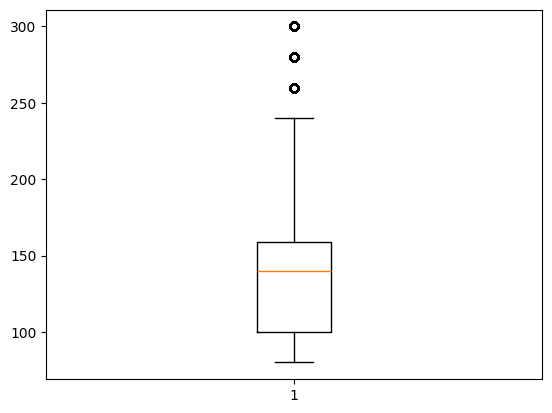

In [95]:
# BLood Glucose Level seems to have outliers 

plt.boxplot(df['blood_glucose_level'])
plt.show()

In [10]:
# Imbalanced classification problem
df['diabetes'].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

In [53]:
# higher diabetes is seen in cases where the person also heart disease
df.groupby(['diabetes', 'heart_disease'])['bmi'].count()

diabetes  heart_disease
0         0                88825
          1                 2675
1         0                 7233
          1                 1267
Name: bmi, dtype: int64

In [89]:
df.head(4)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0


In [90]:
df['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [95]:
# Cannot understand the labels for this categorical data
df.groupby(['smoking_history', 'diabetes'])['age'].count()

smoking_history  diabetes
No Info          0           34362
                 1            1454
current          0            8338
                 1             948
ever             0            3532
                 1             472
former           0            7762
                 1            1590
never            0           31749
                 1            3346
not current      0            5757
                 1             690
Name: age, dtype: int64

In [96]:
df.sample(4)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
86682,Male,72.0,1,0,former,27.32,4.5,160,0
17291,Male,64.0,0,0,never,26.93,6.6,159,0
2655,Female,7.0,0,0,No Info,25.46,6.5,85,0
31528,Female,46.0,0,0,never,40.82,8.2,240,1


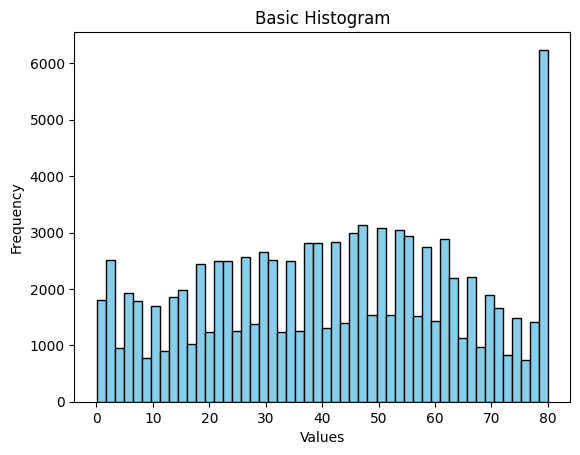

In [11]:
# Checking the values for age
# Plotting a basic histogram for age
# Right skewed data # Plotting a basic histogram

# Display the plot
plt.show()
plt.hist(df['age'], bins=50, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Basic Histogram')

# Display the plot
plt.show()

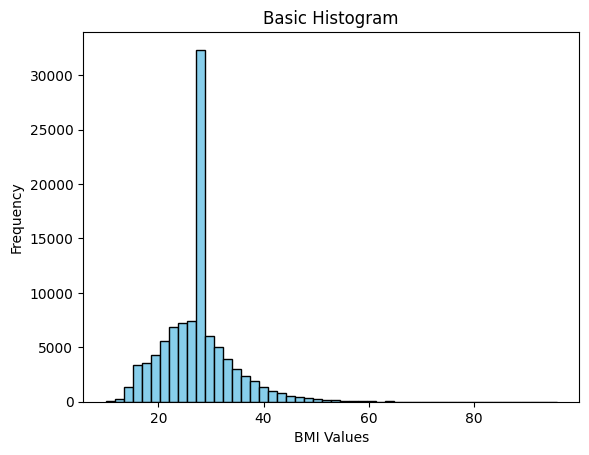

<Figure size 400x200 with 0 Axes>

In [22]:
# Plotting a basic histogram for BMI
# Right skewed data as expected
# Plotting a basic histogram

# Display the plot
plt.hist(df['bmi'], bins=50, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('BMI Values')
plt.ylabel('Frequency')
plt.title('Basic Histogram')

f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)

# Display the plot
plt.show()

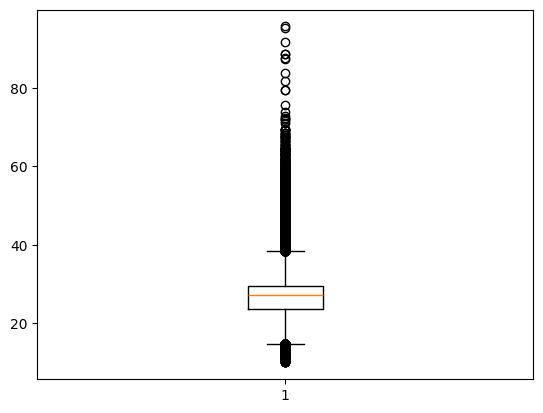

<Figure size 200x100 with 0 Axes>

In [25]:
# The relationship between BMI and diabetes has to be explored 
plt.boxplot(df['bmi'])
fig = plt.figure()
fig.set_figwidth(2)
fig.set_figheight(1)
plt.show()

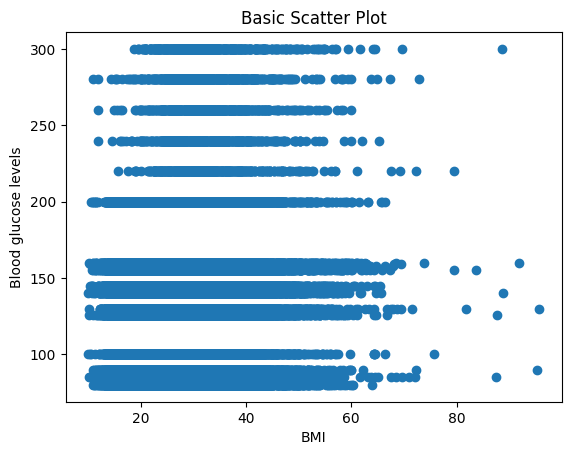

In [13]:
# Plotting BMI and blood glucose levels
# Does not seems to have much of a mapping

plt.scatter(df['bmi'], df['blood_glucose_level'])
plt.title("Basic Scatter Plot")
plt.xlabel("BMI")
plt.ylabel("Blood glucose levels")
plt.show()

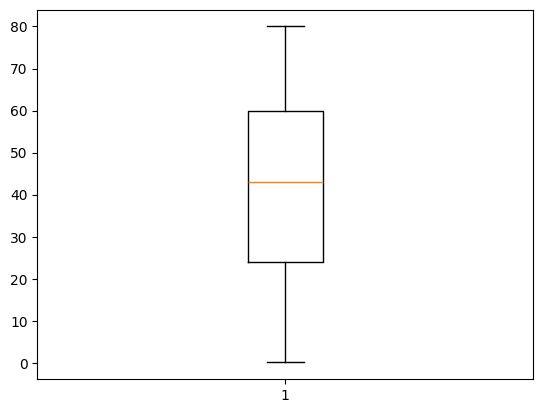

In [17]:
plt.boxplot(df['age'])
plt.show()

## Feature Selection

In [94]:
# Checking the categorical features first
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [95]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(exclude=['object', 'category']).columns.tolist()

# FOr the inputs
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)


label_encoders = {}
# for the train_dataset
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    label_encoders[col] = le  # Save encoder


# for the test dataset 
le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)
y_train_enc, y_test_enc

(array([0, 0, 0, ..., 0, 0, 0], shape=(67000,)),
 array([0, 0, 0, ..., 0, 0, 0], shape=(33000,)))

In [ ]:
# For categorcial -> Categorical : Chi2, Mutual Information
# For numerical -> Categorical : Anova, Mutual Information
# For numerical -> numerical : Pearson, Spearman

Feature gender score : 38.897026102178906
Feature age score : 52729.68719458338
Feature hypertension score : 2372.6899217289892
Feature heart_disease score : 2123.178056801876
Feature smoking_history score : 965.7501408337922
Feature bmi score : 4961.5930462087945
Feature HbA1c_level score : 2232.7840958437855
Feature blood_glucose_level score : 139294.25097482224


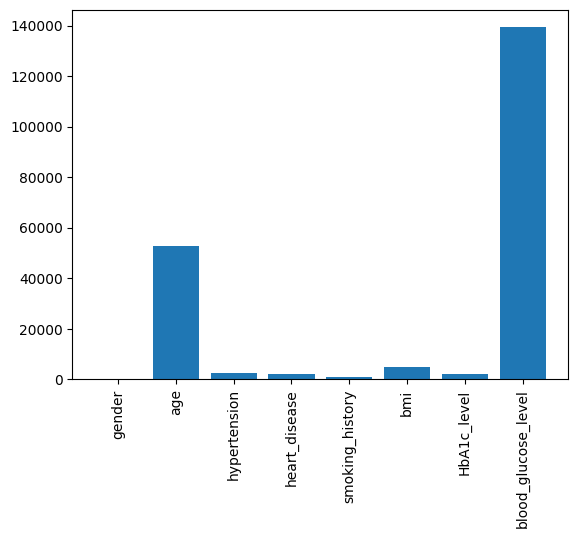

'success'

In [109]:
def feature_selector_chi2_categorical(X_train = None, y_train = None) -> tuple:
    """
    Chi2 feature selector
    Here unfortunately what has happened is that all features have been evaluated including the numerical ones
    """
    try:
        if not (X_train.empty and y_train.empty):
            feature_selector_KBest = SelectKBest(score_func=chi2, k='all')
            feature_selector_KBest.fit(X_train, y_train)
            X_train_fs = feature_selector_KBest.transform(X_train)
            X_test_fs = feature_selector_KBest.transform(X_test)
            return 'success', X_train_fs, X_test_fs, feature_selector_KBest
        else:
            raise ValueError('Features/Targets are empty')

    except ValueError as val_error:
        return val_error, None, None, None
    except Exception as e:
        return str(e), None, None, None

def get_results_categorical(X_train, y_train) -> str:
    """
    Can be performed with Chi2 and Mutual Information Score
    """
    try:
        msg, X_train_fs, X_test_fs, feature_selector_KBest=feature_selector_chi2_categorical(X_train, y_train)
        if msg!= 'success':
            print(msg)
        else:
            for i in range(len(feature_selector_KBest.scores_)):
                print(f'Feature {X_train.columns[i]} score : {feature_selector_KBest.scores_[i]}')
                # plot the scores

            plt.bar(X_train.columns, feature_selector_KBest.scores_)
            plt.xticks(rotation = 90)
            plt.show()
    
        return 'success'
    except Exception as e:
        print(str(e))

get_results_categorical(X_train, y_train)

Feature gender score : 0.005245842019691915
Feature age score : 0.04139959883233235
Feature hypertension score : 0.012511402907275038
Feature heart_disease score : 0.010634166002351453
Feature smoking_history score : 0.01562776700576851
Feature bmi score : 0.024823108303873243
Feature HbA1c_level score : 0.13043131894764337
Feature blood_glucose_level score : 0.1104801070788688


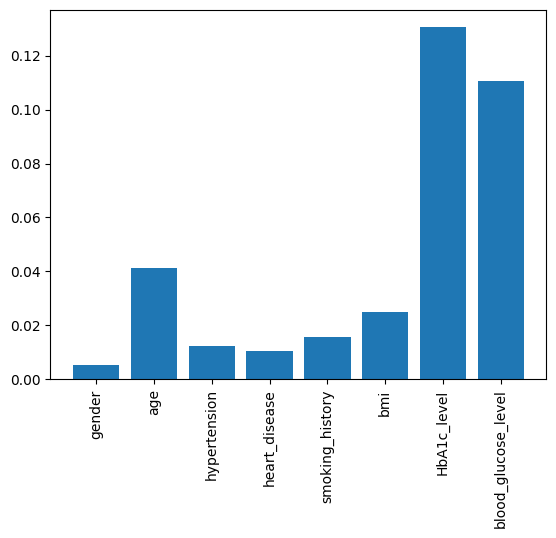

'success'

In [112]:
def feature_selector_MutualInfo_numerical(X_train = None, y_train = None) -> tuple:
    """
    Mutual Info feature selector
    Mutual Infor should be used for numerical and categorical features
    """
    try:
        if not (X_train.empty and y_train.empty):
            feature_selector_KBest = SelectKBest(score_func=mutual_info_classif, k='all')
            feature_selector_KBest.fit(X_train, y_train)
            X_train_fs = feature_selector_KBest.transform(X_train)
            X_test_fs = feature_selector_KBest.transform(X_test)
            return 'success', X_train_fs, X_test_fs, feature_selector_KBest
        else:
            raise ValueError('Features/Targets are empty')

    except ValueError as val_error:
        return val_error, None, None, None
    except Exception as e:
        return str(e), None, None, None

def get_results_numerical(X_train, y_train) -> str:
    """
    Can be performed with ANOVA and Mutual Information Score
    """
    try:
        msg, X_train_fs, X_test_fs, feature_selector_KBest=feature_selector_MutualInfo_numerical(X_train, y_train)
        if msg!= 'success':
            print(msg)
        else:
            for i in range(len(feature_selector_KBest.scores_)):
                print(f'Feature {X_train.columns[i]} score : {feature_selector_KBest.scores_[i]}')
                # plot the scores

            plt.bar(X_train.columns, feature_selector_KBest.scores_)
            plt.xticks(rotation = 90)
            plt.show()
    
        return 'success'
    except Exception as e:
        print(str(e))

get_results_numerical(X_train, y_train)